In [1]:
import numpy as np 

def edge2mat(link, num_node):
    A = np.zeros((num_node, num_node))
    for i, j in link:
        A[j, i] = 1
    return A

def normalize_digraph(A, dim=0):
    # A is a 2D square array
    Dl = np.sum(A, dim)
    h, w = A.shape
    Dn = np.zeros((w, w))

    for i in range(w):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i] ** (-1)

    AD = np.dot(A, Dn)
    return AD

class Graph:
    """The Graph to model the skeletons.

    Args:
        layout (str): must be one of the following candidates: 'mediapipe'. Default: 'mediapipe'.
        mode (str): must be one of the following candidates: 'stgcn_spatial', 'spatial'. Default: 'spatial'.
        max_hop (int): the maximal distance between two connected nodes.
            Default: 1
    """

    def __init__(self,
                layout='mediapipe',
                mode='spatial',
                max_hop=1,
                nx_node=1,
                num_filter=3,
                init_std=0.02,
                init_off=0.04):

        self.max_hop = max_hop
        self.layout = layout
        self.mode = mode
        self.num_filter = num_filter
        self.init_std = init_std
        self.init_off = init_off
        self.nx_node = nx_node

        assert nx_node == 1 or mode == 'random', "nx_node can be > 1 only if mode is 'random'"
        assert layout in ['mediapipe']

        self.get_layout(layout)
       #  self.hop_dis = get_hop_distance(self.num_node, self.inward, max_hop)

        assert hasattr(self, mode), f'Do Not Exist This Mode: {mode}'
        self.A = getattr(self, mode)()

    def __str__(self):
        return self.A

    def get_layout(self, layout):
        if layout == 'mediapipe':
            self.num_node = 33
            self.inward = [
                # Torso
                (12, 11), (24, 12), (24, 23), (23, 11),  # shoulders to hips
                # Right arm
                (14, 12), (16, 14), (18, 16), (20, 18), (20, 22),  # shoulder to fingertip
                # Left arm
                (13, 11), (15, 13), (17, 15), (19, 17), (21, 19),  # shoulder to fingertip
                # Right leg
                (26, 24), (28, 26), (30, 28), (32, 30),  # hip to foot
                # Left leg
                (25, 23), (27, 25), (29, 27), (31, 29),  # hip to foot
                # Face
                (1, 0), (2, 1), (3, 2), (7, 3),  # right eye
                (4, 0), (5, 4), (6, 5), (8, 6),  # left eye
                (10, 9),  # mouth
                # Add connections to nose (0) from shoulders
                # (0, 11), (0, 12)  # do we include this connection dear friend?
            ]
            self.center = 11  # Left shoulder as the center
        else:
            raise ValueError(f'Do Not Exist This Layout: {layout}')
        self.self_link = [(i, i) for i in range(self.num_node)]
        self.outward = [(j, i) for (i, j) in self.inward]
        self.neighbor = self.inward + self.outward

    def spatial(self):
        Iden = edge2mat(self.self_link, self.num_node)
        In = normalize_digraph(edge2mat(self.inward, self.num_node))
        Out = normalize_digraph(edge2mat(self.outward, self.num_node))
        A = np.stack((Iden, In, Out))
        return A

In [2]:
graph = Graph()
A = graph.A

(3, 33, 33)


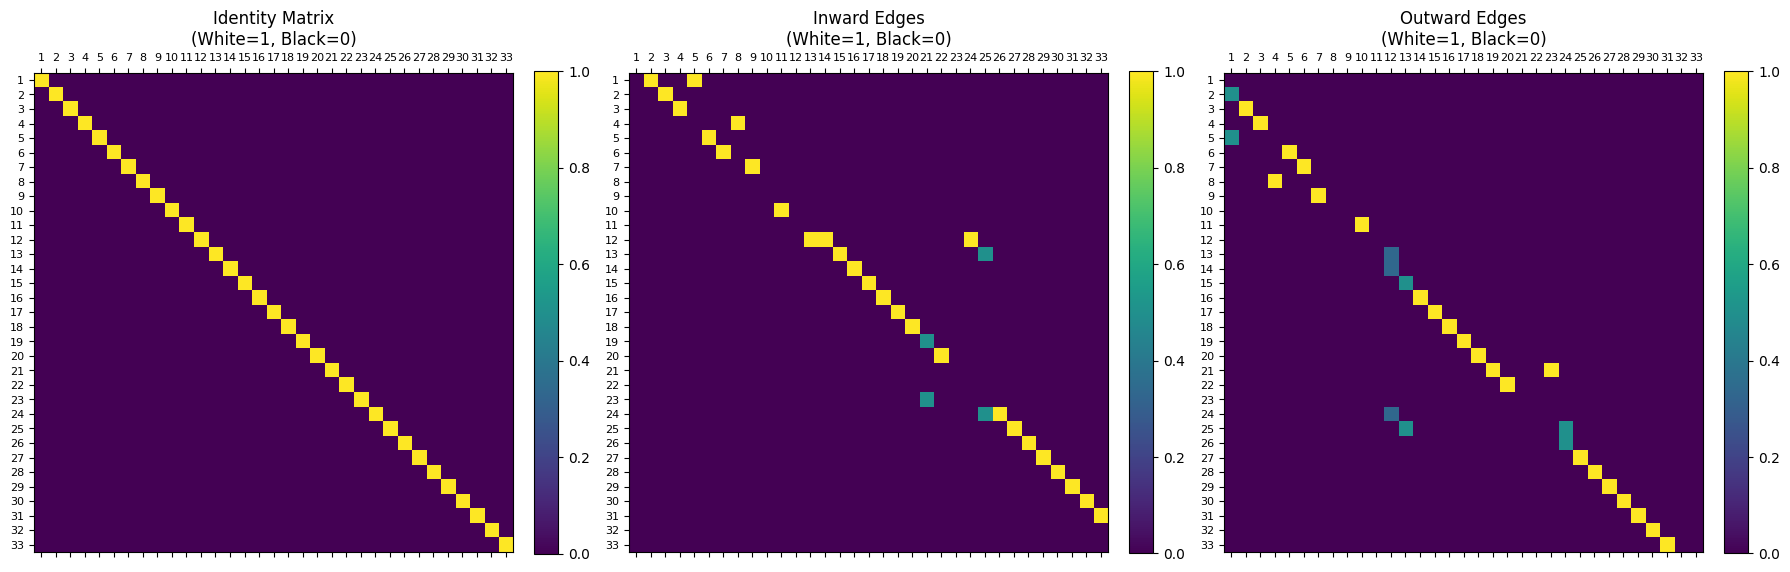

In [3]:
print(A.shape)  # Should be (3, 33, 33)

# Visualize connections with color explanations and larger size
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot identity matrix
im0 = axes[0].matshow(A[0], cmap='viridis')
axes[0].set_title('Identity Matrix\n(White=1, Black=0)')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Plot inward edges
im1 = axes[1].matshow(A[1], cmap='viridis')
axes[1].set_title('Inward Edges\n(White=1, Black=0)')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Plot outward edges
im2 = axes[2].matshow(A[2], cmap='viridis')
axes[2].set_title('Outward Edges\n(White=1, Black=0)')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

# Add node numbers
for ax in axes:
    ax.set_xticks(range(33))
    ax.set_yticks(range(33))
    ax.set_xticklabels(range(1, 34))
    ax.set_yticklabels(range(1, 34))
    ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

In [4]:
# Find and print indices where value == 0.5
for i in range(A.shape[1]):
    for j in range(A.shape[2]):
        if A[1, i, j] == 0.5 or A[2, i, j] == 0.5:
            print(f"({i}, {j}) has value 0.5")


(1, 0) has value 0.5
(4, 0) has value 0.5
(12, 24) has value 0.5
(14, 12) has value 0.5
(18, 20) has value 0.5
(22, 20) has value 0.5
(23, 24) has value 0.5
(24, 12) has value 0.5
(24, 23) has value 0.5
(25, 23) has value 0.5


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class AGCN(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 adaptive='init',
                 conv_pos='pre',
                 with_res=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.graph = Graph()
        A = torch.tensor(self.graph.A, dtype=torch.float32, requires_grad=False)
        self.num_subsets = A.size(0)
        print("NUM_SUBSET:", self.num_subsets)
        self.adaptive = adaptive
        self.conv_pos = conv_pos
        self.with_res = with_res

        self.A = nn.Parameter(A.clone())

        if self.conv_pos == 'pre':
            self.conv = nn.Conv2d(in_channels, out_channels * self.num_subsets, 1)
        elif self.conv_pos == 'post':
            self.conv = nn.Conv2d(self.num_subsets * in_channels, out_channels, 1)

        if self.with_res:
            if in_channels != out_channels:
                self.residual = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1),
                    nn.BatchNorm2d(out_channels))
            else:
                self.residual = lambda x: x

        self.batch_norm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        n, c, t, v = x.shape
        res = self.residual(x) if self.with_res else 0

        A = self.A

        if self.conv_pos == 'pre':
            x = self.conv(x)
            x = x.view(n, self.num_subsets, -1, t, v)
            x = torch.einsum('nkctv,kvw->nctw', (x, A)).contiguous()
        elif self.conv_pos == 'post':
            x = torch.einsum('nctv,kvw->nkctw', (x, A)).contiguous()
            x = x.view(n, -1, t, v)
            x = self.conv(x)

        return F.relu(self.batch_norm(x) + res)

    def init_weights(self):
        pass

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        if hasattr(m, 'weight'):
            nn.init.kaiming_normal_(m.weight, mode='fan_out')
        if hasattr(m, 'bias') and m.bias is not None and isinstance(m.bias, torch.Tensor):
            nn.init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            m.weight.data.normal_(1.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.fill_(0)

In [7]:
class STSAM(nn.Module):
    def __init__(self, in_channels):
        super(STSAM, self).__init__()

        # 1x1 convolutions for Q, K, V
        self.query_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        # 1x1 convolutions for scaling attention maps
        self.Ws = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.Wt = nn.Conv2d(in_channels, 1, kernel_size=1)

    def forward(self, x):
        N, C, T, V = x.size()

        # Generate Q, K, V
        Q = self.query_conv(x)
        K = self.key_conv(x)
        V = self.value_conv(x)

        # Spatial attention
        Qs = torch.mean(Q, dim=2, keepdim=True)  # (N, C, 1, V)
        Ks = torch.mean(K, dim=2, keepdim=True)  # (N, C, 1, V)
        Vs = torch.mean(V, dim=2, keepdim=True)  # (N, C, 1, V)

        # Temporal attention
        Qt = torch.mean(Q, dim=3, keepdim=True)  # (N, C, T, 1)
        Kt = torch.mean(K, dim=3, keepdim=True)  # (N, C, T, 1)
        Vt = torch.mean(V, dim=3, keepdim=True)  # (N, C, T, 1)

        # Compute attention maps
        Ms = torch.matmul(Qs.transpose(2, 3), Ks) / torch.sqrt(torch.tensor(C, dtype=torch.float))  # Spatial attention
        Ms = torch.softmax(Ms, dim=-1)
        Ms = torch.matmul(Ms, Vs.transpose(2, 3)).transpose(2, 3)

        Mt = torch.matmul(Qt.transpose(2, 3), Kt) / torch.sqrt(torch.tensor(C, dtype=torch.float))  # Temporal attention
        Mt = torch.softmax(Mt, dim=-1)
        Mt = torch.matmul(Mt, Vt.transpose(2, 3)).transpose(2, 3)

        # Scale attention maps
        Ms1 = torch.sigmoid(self.Ws(Ms))  # (N, 1, 1, V)
        Mt1 = torch.sigmoid(self.Wt(Mt))  # (N, 1, T, 1)

        # Apply attention with residual connections
        out = (x + x * Ms1) + ( x * Mt1)

        return out, Ms1, Mt1

In [8]:
class TemporalConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1):
        super(TemporalConv, self).__init__()
        pad = (kernel_size + (kernel_size-1) * (dilation-1) - 1) // 2
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=(kernel_size, 1),
            padding=(pad, 0),
            stride=(stride, 1),
            dilation=(dilation, 1))

        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class MTCN(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 dilations=[1,2,3,4],
                 residual=True,
                 residual_kernel_size=1):

        super().__init__()
        assert out_channels % (len(dilations) + 2) == 0, '# out channels should be multiples of # branches'

        # Multiple branches of temporal convolution
        self.num_branches = len(dilations) + 2
        branch_channels = out_channels // self.num_branches
        if type(kernel_size) == list:
            assert len(kernel_size) == len(dilations)
        else:
            kernel_size = [kernel_size]*len(dilations)
        # Temporal Convolution branches
        self.branches = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    branch_channels,
                    kernel_size=1,
                    padding=0),
                nn.BatchNorm2d(branch_channels),
                nn.ReLU(inplace=True),
                TemporalConv(
                    branch_channels,
                    branch_channels,
                    kernel_size=ks,
                    stride=stride,
                    dilation=dilation),
            )
            for ks, dilation in zip(kernel_size, dilations)
        ])

        # Additional Max & 1x1 branch
        self.branches.append(nn.Sequential(
            nn.Conv2d(in_channels, branch_channels, kernel_size=1, padding=0),
            nn.BatchNorm2d(branch_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3,1), stride=(stride,1), padding=(1,0)),
            nn.BatchNorm2d(branch_channels)
        ))

        self.branches.append(nn.Sequential(
            nn.Conv2d(in_channels, branch_channels, kernel_size=1, padding=0, stride=(stride,1)),
            nn.BatchNorm2d(branch_channels)
        ))

        # Residual connection
        if not residual:
            self.residual = lambda x: 0
        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x
        else:
            self.residual = TemporalConv(in_channels, out_channels, kernel_size=residual_kernel_size, stride=stride)

        # initialize
        self.apply(weights_init)

    def forward(self, x):
        # Input dim: (N,C,T,V)
        res = self.residual(x)
        branch_outs = []
        for tempconv in self.branches:
            out = tempconv(x)
            branch_outs.append(out)

        out = torch.cat(branch_outs, dim=1)
        out += res
        return out

# PARALLEL Self_Attention

In [9]:
# class STSAE_GCN_Block(nn.Module):
#     def __init__(self, in_channels, out_channels, residual= True, stride =1):
#         super(STSAE_GCN_Block, self).__init__()
#         self.agcn = AGCN(in_channels, out_channels)
#         self.stsam = STSAM(out_channels)
#         self.mtcn = MTCN(out_channels, out_channels)
#         self.relu = nn.ReLU()
#         if not residual:
#             self.residual = lambda x: 0
#         elif (in_channels == out_channels) and (stride == 1):
#             self.residual = lambda x: x
#         else:
#             self.residual =TemporalConv(in_channels, out_channels, kernel_size=1, stride=stride)
#     def forward(self, x):
#         res = self.residual(x)
#         x = self.agcn(x)
#         x = self.stsam(x)
#         x = self.mtcn(x) + res
#         # x = x + res
#         return self.relu(x)

# Sequential Soft-Attention

In [10]:
JOINT_COUNT=33
class SAM(nn.Module):
    def __init__(self, in_channels, joint_count=JOINT_COUNT):
        super(SAM, self).__init__()
        
        # Conv1D over joints (V), capturing spatial dependencies
        ks = joint_count if joint_count % 2 else joint_count - 1  # Ensure odd kernel size
        padding = (ks - 1) // 2
        self.gs = nn.Conv1d(in_channels, 1, kernel_size=ks, padding=padding)
        
        # Pool over time (T) only, preserve joints (V)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, None))  # Collapses T, keeps V unchanged
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        N, C, T, V = x.shape
        # Pool along time (T) dimension only
        t = self.avg_pool(x)  # (N, C, 1, V)
        
        t = t.squeeze(2)
        t = self.gs(t) # (N, 1, V)
        Ms = self.sigmoid(t)  
        Ms = Ms.unsqueeze(2)
        return (x + x * Ms), Ms

class TAM(nn.Module):
    def __init__(self, in_channels, temporal_size=9):
        super(TAM, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((None, 1))  # Keep temporal dim, pool joints
        padding = ((temporal_size)//2)
        self.gt = nn.Conv1d(in_channels, 1, kernel_size=temporal_size, padding=padding)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pool over joints (V) while keeping temporal dimension
        t = self.avg_pool(x).squeeze(-1)  # (N, C, T)
        print("t shape:", t.shape)
        t = self.gt(t)  # (N, 1, T)
        print("t shape:", t.shape)
        Mt = self.sigmoid(t).unsqueeze(-1)  # (N, 1, T, 1)
        print("Mt shape:", Mt.shape)
        return x * Mt + x, Mt


class CAM(nn.Module):
    def __init__(self, in_channels, reduction=2):
        super(CAM, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # Combine the operations into a single sequential block
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.ReLU(),  # δ applied to entire W1 term
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        n, c, _, _ = x.shape
        t = self.avg_pool(x).view(n, c)
        Mc = self.fc(t).view(n, c, 1, 1)
        return x * Mc + x, Mc

In [11]:
# Create dummy data with shape (batch_size, channels, time_steps, joints)
batch_size = 2
channels = 64
time_steps = 30
joints = 33

dummy_data = torch.randn(batch_size, channels, time_steps, joints)

# Initialize TAM module
tam = TAM(in_channels=channels, 20)

# Forward pass
output, attention_map = tam(dummy_data)

print("Input shape:", dummy_data.shape)
print("Output shape:", output.shape)
print("Attention map shape:", attention_map.shape)


SyntaxError: positional argument follows keyword argument (435798797.py, line 10)

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class STSAE_GCN_Block(nn.Module):
    def __init__(self, in_channels, out_channels, residual=True, stride=1):
        super(STSAE_GCN_Block, self).__init__()

        # Graph Convolution
        self.agcn = AGCN(in_channels, out_channels)

        # Attention Modules
        self.sam = SAM(out_channels)  # Spatial Attention
        self.tam = TAM(out_channels)  # Temporal Attention
        self.cam = CAM(out_channels)  # Channel Attention

        # Multi-Scale Temporal Convolution Network
        self.mtcn = MTCN(out_channels, out_channels)

        # Residual Connection
        if not residual:
            self.residual = lambda x: 0
        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x
        else:
            self.residual = TemporalConv(in_channels, out_channels, kernel_size=1, stride=stride)

        # Activation
        self.relu = nn.ReLU()

        # Store Attention Maps
        self.Ms = None  # Spatial Attention Map
        self.Mt = None  # Temporal Attention Map
        self.Mc = None  # Channel Attention Map

    def forward(self, x):
        res = self.residual(x)

        # Apply Graph Convolution
        x = self.agcn(x)

        # Apply Attention Modules and Store Attention Maps
        x, self.Ms = self.sam(x)  # Spatial Attention
        x, self.Mt = self.tam(x)  # Temporal Attention
        x, self.Mc = self.cam(x)  # Channel Attention

        # Apply Multi-Scale Temporal Convolution
        x = self.mtcn(x) + res

        return self.relu(x)

    def get_attention(self):
        """
        Returns the stored attention maps.
        """
        return {"Ms": self.Ms, "Mt": self.Mt, "Mc": self.Mc}

In [83]:

class STSAE_GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, num_frames, num_blocks=9):
        super(STSAE_GCN, self).__init__()
        self.num_blocks = num_blocks
        num_nodes = 33
        self.batch_norm = nn.BatchNorm1d(in_channels* num_nodes)
        self.blocks = nn.ModuleList([
            STSAE_GCN_Block(in_channels if i == 0 else hidden_channels,
                            hidden_channels, residual=False if i == 0 else True)
            for i in range(num_blocks)
        ])
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        self.fc = nn.Linear(hidden_channels, num_classes)  # Only hidden_channels remain after pooling

    def forward(self, x):
        # x shape: (batch_size, in_channels, num_frames, num_nodes)
        
        # print("SHAPE X:", x.shape)
        N, C, T, V = x.size()
        x = x.permute(0,3,1,2).contiguous()
        x = x.view(N, V*C, T)
        x = self.batch_norm(x)
        x = x.view(N, V,C, T).permute(0,2,3,1)

        for block in self.blocks:
            x = block(x)
            print("X SHAPE:", x.shape)

        # Apply Global Average Pooling
        x = self.avg_pool(x).squeeze(-1).squeeze(-1)  # Reduce to (batch_size, hidden_channels)

        # Fully connected layer
        x = self.fc(x)
        return x

    def count_parameters(self):
        total_params = 0
        for name, parameter in self.named_parameters():
            if parameter.requires_grad:
                params = parameter.numel()
                print(f"{name}: {params}")
                total_params += params
        print(f"Total Trainable Params: {total_params}")


In [84]:
# Create dummy data
batch_size = 8
in_channels = 3  # x, y, confidence
num_frames = 30  # 1 second of video at 30 fps
num_nodes = 33  # BlazePose skeleton

# Generate random data in range [0, 1] for x, y coordinates and confidence
dummy_data = torch.rand(batch_size, in_channels, num_frames, num_nodes)

# Create model instance
model = STSAE_GCN(in_channels=in_channels, 
                 hidden_channels=66, 
                 num_classes=10, 
                 num_frames=num_frames,
                 num_blocks=9)

# Forward pass
output = model(dummy_data)
print(f"Input shape: {dummy_data.shape}")
print(f"Output shape: {output.shape}")
print(f"Sample output: {output[0]}")
model.count_parameters()


NUM_SUBSET: 3
NUM_SUBSET: 3
NUM_SUBSET: 3
NUM_SUBSET: 3
NUM_SUBSET: 3
NUM_SUBSET: 3
NUM_SUBSET: 3
NUM_SUBSET: 3
NUM_SUBSET: 3
t shape: torch.Size([8, 66, 30])
t shape: torch.Size([8, 1, 30])
Mt shape: torch.Size([8, 1, 30, 1])
X SHAPE: torch.Size([8, 66, 30, 33])
t shape: torch.Size([8, 66, 30])
t shape: torch.Size([8, 1, 30])
Mt shape: torch.Size([8, 1, 30, 1])
X SHAPE: torch.Size([8, 66, 30, 33])
t shape: torch.Size([8, 66, 30])
t shape: torch.Size([8, 1, 30])
Mt shape: torch.Size([8, 1, 30, 1])
X SHAPE: torch.Size([8, 66, 30, 33])
t shape: torch.Size([8, 66, 30])
t shape: torch.Size([8, 1, 30])
Mt shape: torch.Size([8, 1, 30, 1])
X SHAPE: torch.Size([8, 66, 30, 33])
t shape: torch.Size([8, 66, 30])
t shape: torch.Size([8, 1, 30])
Mt shape: torch.Size([8, 1, 30, 1])
X SHAPE: torch.Size([8, 66, 30, 33])
t shape: torch.Size([8, 66, 30])
t shape: torch.Size([8, 1, 30])
Mt shape: torch.Size([8, 1, 30, 1])
X SHAPE: torch.Size([8, 66, 30, 33])
t shape: torch.Size([8, 66, 30])
t shape: torc

In [85]:

# class STSAE_GCN(nn.Module):
#     def __init__(self, in_channels, hidden_channels, num_classes, num_frames, num_blocks=9):
#         super(STSAE_GCN, self).__init__()
#         self.num_blocks = num_blocks

#         self.blocks = nn.ModuleList([
#             STSAE_GCN_Block(in_channels if i == 0 else hidden_channels,
#                             hidden_channels, residual=False if i == 0 else True)
#             for i in range(num_blocks)
#         ])
#         num_nodes = 33
#         self.fc = nn.Linear(hidden_channels * num_nodes * num_frames, num_classes)

#     def forward(self, x):
#         # x shape: (batch_size, in_channels, num_frames, num_nodes)
#         for block in self.blocks:
#             x = block(x)

#         # Global average pooling
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

In [86]:
def load_checkpoint(model, optimizer, checkpoint_path):
    """
    Load model and training state from a checkpoint
    """
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, weights_only = False,map_location='cpu')

    # Load model and optimizer states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Get the epoch number to resume from
    start_epoch = checkpoint['epoch']

    # Load training history with new metrics
    history = checkpoint.get('history', {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'train_recall': [], 'train_f1': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'learning_rates': []
    })

    return model, optimizer, start_epoch, history

In [87]:
# dataset = Yoga3DDataset(read_meta_data())
# label_to_pose = {v:k for k,v in dataset.pose_to_label.items()}
HIDDEN_CHANNELS = 120
NUM_CLASSES = 13
NUM_BLOCKS = 7
model = STSAE_GCN(3, HIDDEN_CHANNELS, NUM_CLASSES, 20,num_blocks=NUM_BLOCKS)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

import os
SAVE_PATH = './'
checkpoint_path = os.path.join(SAVE_PATH, 'best_model.pth')
# Plot the training curves
if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, history = load_checkpoint(
            model, optimizer, checkpoint_path
        )
        print(f"Resuming training from epoch {start_epoch}")
# plot_training_curves(history)

NUM_SUBSET: 3
NUM_SUBSET: 3
NUM_SUBSET: 3
NUM_SUBSET: 3
NUM_SUBSET: 3
NUM_SUBSET: 3
NUM_SUBSET: 3


In [88]:
model

STSAE_GCN(
  (batch_norm): BatchNorm1d(99, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): ModuleList(
    (0): STSAE_GCN_Block(
      (agcn): AGCN(
        (conv): Conv2d(3, 360, kernel_size=(1, 1), stride=(1, 1))
        (batch_norm): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (sam): SAM(
        (gs): Conv1d(120, 1, kernel_size=(33,), stride=(1,), padding=(16,))
        (avg_pool): AdaptiveAvgPool2d(output_size=(1, None))
        (sigmoid): Sigmoid()
      )
      (tam): TAM(
        (avg_pool): AdaptiveAvgPool2d(output_size=(None, 1))
        (gt): Conv1d(120, 1, kernel_size=(9,), stride=(1,), padding=(4,))
        (sigmoid): Sigmoid()
      )
      (cam): CAM(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=120, out_features=60, bias=True)
          (1): ReLU()
          (2): Linear(in_features=60, out_features=120, bias=True)
          (